### 测试
使用matplot展示图像的时候发现图像存在失真问题
原因：其实并不是失真，而是在导入图片时使用了opencv，正常展示顺序是RGB，而opencv的读取顺序是BGR，所以蓝色和红色的通道反了因此在读取图像前面加两行转换一下即可。

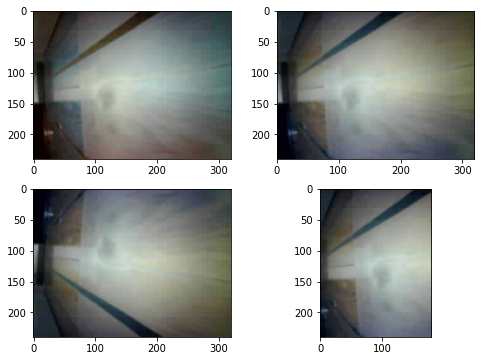

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

plt.figure("img", figsize = (8, 6))
plt.title("Image read test")
img = cv2.imread("data/549.jpg")
plt.subplot(2, 2, 1)
plt.imshow(img)

b, g, r = cv2.split(img)
img2 = cv2.merge([r, g, b])
plt.subplot(2, 2, 2)
plt.imshow(img2)

img3 = cv2.flip(img2, 0)
plt.subplot(2, 2, 3)
plt.imshow(img3)

img4 = img2[:, 20:200]
plt.subplot(2, 2, 4)
plt.imshow(img4)
plt.show()

测试使用GPU

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()
!/opt/bin/nvidia-smi

ϵͳ�Ҳ���ָ����·����


### 图像处理及增强

In [4]:
import numpy as np
import cv2, csv

#### 翻转
通过翻转图像和转向角度，网络能够学习这两种情况，并且不会偏向左转或右转。

In [5]:
def flip(img):
    return cv2.flip(img, 0)

#### 高斯模糊
高斯模糊有助于减少图像噪声和细节，从而平滑训练数据。

In [6]:
def process_image(img, kernel_size=5):
    """
    Preprocess IMG with a Gaussian Blur and 
    convert it from BGR color channel to RGB color channel
    """
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

#### 随机亮度调整
随机调整图像的亮度有助于模型更好地泛化到更多光照情况。

In [7]:
def adjust_brightness_RGB(img):
    """
    Adjust brightness of the IMG, whose color is in RGB
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    ratio = 0.9 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

#### 随机变换调整
左右随机变换图像有助于模型更好地泛化到更多未经训练的视角。

In [8]:
def random_translate(image, steering_angle, range_x=100, range_y=10):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_y], [0, 1, trans_x]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

#### 随机阴影
向左右图像随机添加阴影有助于模型更好地泛化到更多的情况，即一半的道路在树的阴影中，从而在同一条道路上出现不均匀的照明情况。这是丛林赛道较为突出的情况。

In [9]:
def random_shadow(image):
    """
    Generates and adds random shadow
    """
    IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = image.shape
    x1, y1 = IMAGE_WIDTH * np.random.rand() / 4, 0
    x2, y2 = IMAGE_WIDTH * np.random.rand() / 4, IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1
    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.5, high=0.8)
    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

#### 应用增强

测试

read image 92


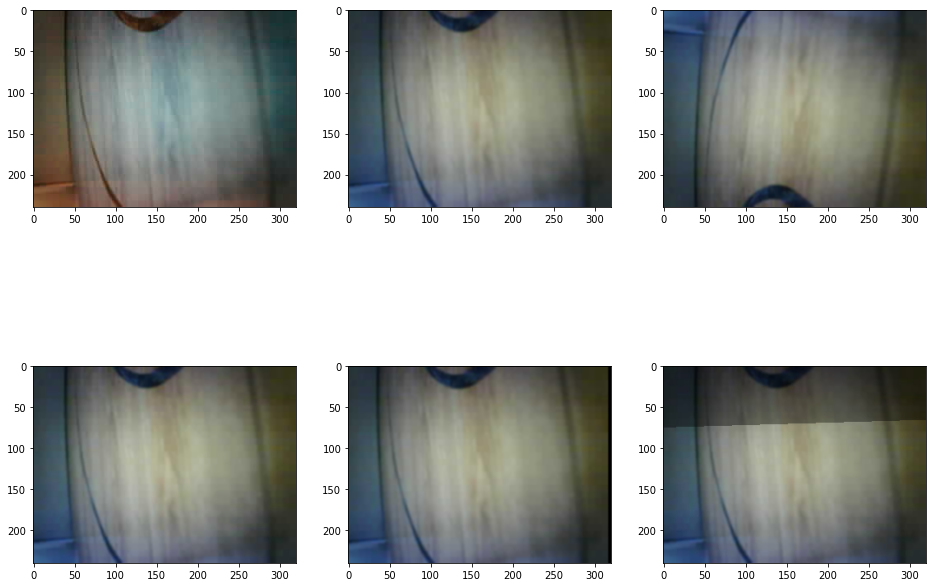

In [10]:
img_num = np.random.randint(1, 100)
print("read image", img_num)

plt.figure("Apply enhancements", figsize=(16, 12))
plt.subplot(2, 3, 1)    # 原始图片
img = cv2.imread("data/{}.jpg".format(img_num))
plt.imshow(img)

plt.subplot(2, 3, 2)    # 高斯模糊
origin_img = process_image(img)
plt.imshow(origin_img)

plt.subplot(2, 3, 3)    # 翻转
flip_img = flip(origin_img)
plt.imshow(flip_img)

plt.subplot(2, 3, 4)    # 随机亮度
bright_img = adjust_brightness_RGB(origin_img)
plt.imshow(bright_img)

plt.subplot(2, 3, 5)    # 随机变换
trans_img, angle = random_translate(origin_img, np.random.rand())
plt.imshow(trans_img)

plt.subplot(2, 3, 6)
shadow_img = random_shadow(origin_img)
plt.imshow(shadow_img)
plt.show()

#### 生成

In [11]:
from sklearn.utils import shuffle

def generator(samples, directory, batch_size=32, preprocess_image=lambda x: x, augment=True, recorder=None):

    def read_img(path):
        return preprocess_image(cv2.imread(path))

    def append_data(lst1, item1, lst2, item2, recorder=None):
        lst1.append(item1)
        lst2.append(item2)
        if recorder is not None:
            recorder.writerow(item2)

    def use_augmentation(prob):
        return True if np.random.random() <= prob else False

    def augment(new_img, new_angle):
        augmented = False
        if augment and use_augmentation(0.4):
            new_img, new_angle = adjust_brightness_RGB(new_img), new_angle
            augmented = True
        if augment and use_augmentation(0.2):
            new_img, new_angle = random_shadow(new_img), new_angle
            augmented = True
        if augment and use_augmentation(0.3):
            new_img, new_angle = random_translate(new_img, new_angle)
            augmented = True
        if not augmented or use_augmentation(0.4):
            new_img, new_angle = flip(new_img), -new_angle

        return new_img, new_angle

    enhanced_csv = None
    if recorder is not None:
        enhanced_csv = csv.writer(recorder, lineterminator="\n")

    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset: offset+batch_size]

            images = []
            steering = []
            for batch_sample in batch_samples:
                image = read_img("{}/{}.jpg".format(directory, batch_sample[0]))
                append_data(images, image, steering, batch_sample[1:], enhanced_csv)
                enhanced_img, batch_sample[1] = augment(image, batch_sample[1])
                if batch_sample[1] > 1:
                    batch_sample[1] = 1
                elif batch_sample[1] < -1:
                    batch_sample[1] = -1
                append_data(images, image, steering, batch_sample[1:], enhanced_csv)
                
            X_train = np.array(images)
            y_train = np.array(steering)
            yield shuffle(X_train, y_train)

#### 模型

In [12]:
from keras.models import Sequential, load_model
from keras.layers import Cropping2D
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D

# def build_model(cropping_box=((0, 0), (20, 120)), input_shape=(240, 320, 3), normalize_fn=lambda x: x / 255 - 0.5):
#     model = Sequential()
#     model.add(Cropping2D(cropping=cropping_box, input_shape=input_shape))
#     model.add(Lambda(normalize_fn))
#     model.add(Convolution2D(24, (5, 5), strides=(2,2), activation="elu"))
#     model.add(Convolution2D(36, (5, 5), strides=(2,2), activation="elu"))
#     model.add(Convolution2D(48, (5, 5), strides=(2,2), activation="elu"))
#     model.add(Convolution2D(48, (3, 3), activation="elu"))
#     model.add(Convolution2D(64, (3, 3), activation="elu"))
#     keep_prob = 0.7
#     model.add(Dropout(keep_prob))
#     model.add(Flatten())
#     model.add(Dense(100))
#     model.add(Activation("elu"))
#     model.add(Dropout(keep_prob))
#     model.add(Dense(50))
#     model.add(Activation("elu"))
#     model.add(Dropout(keep_prob))
#     model.add(Dense(10))
#     model.add(Activation("elu"))
#     model.add(Dropout(keep_prob))
#     model.add(Dense(2))
#     return model

from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Cropping2D, Lambda
def build_model(cropping_box=((0, 0), (20, 120)), input_shape=(240, 320, 3), normalize_fn=lambda x: x / 255 - 0.5):
    model = Sequential()
    # Crop the input image to filter out irrelevant parts such as the sky
    # and off-road portions on the sides...
    model.add(Cropping2D(cropping=cropping_box, input_shape=input_shape))
    
    # Normalize image with zero mean...
    model.add(Lambda(normalize_fn))
    
    # Implement Lenet architecture...
    model.add(Conv2D(6, (5,5), activation='relu', strides=1, padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
    model.add(Conv2D(16, (5,5), activation='relu', strides=1, padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
    model.add(Conv2D(32, (3,3), activation='relu', strides=1, padding='valid'))
    model.add(Flatten())
    model.add(Dense(400, activation='relu'))
    model.add(Dropout(0.2))         #0.2
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))         #0.2
    model.add(Dense(84, activation='relu')) #64
    model.add(Dropout(0.1))         #0.1
    model.add(Dense(2))
    return model

#### 其他

In [13]:
def get_sample_data(path, random = True):
    """
    This function returns the data columns of the csv file at PATH
    """
    samples = []
    with open(path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            line[0] = int(line[0])
            line[1] = float(line[1])
            line[2] = float(line[2])
            samples.append(line)
    return shuffle(samples) if random else samples

def analyze_samples(datas, column=1):
    """
    Return a dictionary containing count of all steering angles in DATA
    """
    angle_dict = dict()
    for data in datas:
        angle = round(data[column] * 10)
        if angle not in angle_dict:
            angle_dict[angle] = 1
        else:
            angle_dict[angle] += 1
    angle = dict()
    for key in sorted(angle_dict):
        angle[key] = angle_dict[key]
    return angle

def redistribute_samples(data, count_map):
    """
    Return a new dataset by resampling DATA
    """
    average = np.average(list(count_map.values()))
    keep_prob = dict()
    for i in count_map:
        if count_map[i] <= average:
            keep_prob[i] = 1 # keep angles whose count <= than average
        else:
            # keep sample with a probability
            keep_prob[i] = average / count_map[i]
    # Resample Data
    new_data = list()
    for line in data:
        angle = round(line[1] * 10)
        if np.random.random() <= keep_prob[angle]:
            new_data.append(line)
    return np.array(new_data)

#### 训练

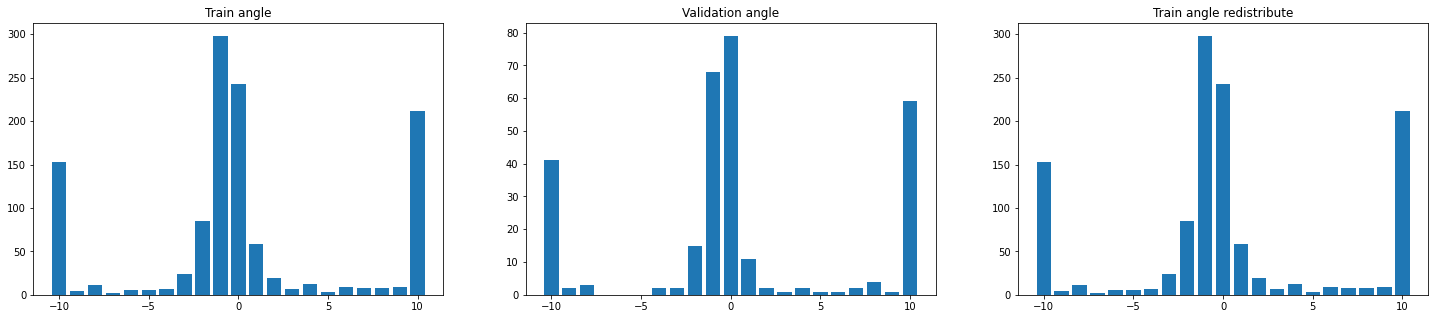

In [14]:
from sklearn.model_selection import train_test_split

model_save = "model.h5"
data_path = "data"
samples = get_sample_data(data_path + "/output.csv")
recorder = open("{}/enhanced.csv".format(data_path), "w")
train_samples, valid_samples = train_test_split(samples, test_size=0.2)
train_generator = generator(train_samples, batch_size=64, directory=data_path, preprocess_image=process_image, recorder=recorder)
valid_generator = generator(valid_samples, batch_size=64, directory=data_path, preprocess_image=process_image)

analyzeed_samples = analyze_samples(train_samples)
# train_samples = redistribute_samples(train_samples, analyzeed_samples)

plt.figure("Angle distribute", figsize=(25, 5))
plt.subplot(1, 3, 1)
plt.title("Train angle")
plt.bar(analyzeed_samples.keys(), analyzeed_samples.values())
plt.subplot(1, 3, 2)
plt.title("Validation angle")
analyzeed_samples = analyze_samples(valid_samples)
plt.bar(analyzeed_samples.keys(), analyzeed_samples.values())
plt.subplot(1, 3, 3)
plt.title("Train angle redistribute")
analyzeed_samples = analyze_samples(train_samples)
plt.bar(analyzeed_samples.keys(), analyzeed_samples.values())
plt.show()

In [15]:
from keras import callbacks

# Uncomment following line if you want to rebuild a new model to train
model = build_model()

# Uncomment following line if you want to keep fine tuning existing model (model.h5)
# model = load_model("model.h5")

model.compile(loss='mse', optimizer='adam', )

early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                    patience=2, verbose=1, mode='auto',
                    baseline=None, restore_best_weights=True)

history = model.fit(
    train_generator, 
    steps_per_epoch=len(train_samples)//3, 
    validation_data=valid_generator, 
    validation_steps=len(valid_samples)//3, 
    epochs=10, 
    verbose=1,
    callbacks=[early_stopping]
)

# Save Model After Training
model.save(model_save)
print("model saved as", model_save)
recorder.close()

Epoch 1/10


Error: Canceled future for execute_request message before replies were done

In [ ]:
print(history.history.keys())

# accuracy的历史
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

# loss的历史
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
def get_enhanced_sample_data(path, random = True):
    """
    This function returns the data columns of the csv file at PATH
    """
    samples = []
    with open(path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            line[0] = float(line[0])
            line[1] = float(line[1])
            samples.append(line)
    return shuffle(samples) if random else samples


data_path = "data"
enhanced_samples = get_enhanced_sample_data(data_path + "/enhanced.csv")
enhanced_distribute = analyze_samples(enhanced_samples, 0)
plt.figure("Enhanced engle distribute")
plt.bar(enhanced_distribute.keys(), enhanced_distribute.values())
plt.show()

#### 测试模型

In [ ]:
from keras.models import load_model

test_model = load_model("model.h5")
test_model.summary()

for i in range(5):
    data = samples[np.random.randint(len(samples))]
    print(data, end="\t")
    image = cv2.imread("data/{}.jpg".format(data[0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_array = np.asarray(image)
    predict = test_model.predict(image_array[None, :, :, :], batch_size = 1)
    print(predict)
    plt.figure()
    plt.imshow(image)
    plt.show()

In [ ]:
from keras.models import load_model

def sort_dict(data):
    new_data = dict()
    for key in sorted(data):
        new_data[key] = data[key]
    return new_data
    

test_model = load_model("model.h5")
img = []
img_num = 0
angle_dict = dict()
speed_dict = dict()
while True:
    img_num += 1
    img_path = "data/{}.jpg".format(img_num)
    if not os.path.exists(img_path):
        break
    img = cv2.imread(img_path)
    img_arr = np.asarray(img)
    img_predict = test_model.predict(img_arr[None, :, :, :], batch_size=1)

    angle = round(img_predict[0][0] * 100)
    if angle not in angle_dict:
        angle_dict[angle] = 1
    else:
        angle_dict[angle] += 1

    speed = round(img_predict[0][1] * 10)
    if speed not in speed_dict:
        speed_dict[speed] = 1
    else:
        speed_dict[speed] += 1

angle = sort_dict(angle_dict)
speed = sort_dict(speed_dict)

In [ ]:
print(img_num, "images have been loaded")
plt.figure("Distribute", figsize=(30,10))
plt.subplot(1, 2, 1)
plt.title("Amgle distribute")
plt.bar(angle.keys(), angle.values(), width=0.5)
plt.subplot(1, 2, 2)
plt.title("Speed distribute")
plt.bar(speed.keys(), speed.values(), width=0.5)
plt.show()

#### 模型转换

.h5 to .tflite model

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
!pip3 install nncase-1.5.0.20220331-cp37-cp37m-manylinux_2_24_x86_64.whl

In [ ]:
import nncase

def read_model_file(model_file):
    with open(model_file, 'rb') as f:
        model_content = f.read()
    return model_content

compile_options = nncase.CompileOptions()
compile_options.target = "k210"
compiler = nncase.Compiler(compile_options)
import_options = nncase.ImportOptions()
model_content = read_model_file("model.tflite")
compiler.import_tflite(model_content, import_options)
compiler.compile()
kmodel = compiler.gencode_tobytes()
with open("model.kmodel", "wb") as f:
    f.write(kmodel)